# Automatic Coastline Classification Using Google Earth Data

## Introduction

In this project, we aim to develop a machine learning algorithm to classify coastline images using data from Google Earth. This project is the first step towards creating a more comprehensive solution for automated coastline delineation, which will later incorporate data from multiple sources.

### Objectives
- Collect and preprocess Google Earth images of coastlines.
- Develop and train machine learning models to classify these images.
- Evaluate the performance of these models using various metrics.


# IMPORT librairies

In [9]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report, f1_score, cohen_kappa_score, matthews_corrcoef
import seaborn as sns
from PIL import Image
from tqdm import tqdm

In [10]:
# Set system encoding to UTF-8 (solve a windows issue with charmpa undefiend)
import sys
sys.stdin.reconfigure(encoding='utf-8')
#sys.stdout.reconfigure(encoding='utf-8')

## Data Collection and Preprocessing

### Data Sources
The data for this project consists of high-resolution images of coastlines captured from Google Earth.

### Preprocessing Steps
1. **Cleaning**: Removing corrupted or low-quality images.
2. **Resizing**: Standardizing image dimensions to ensure compatibility with the models.
3. **Normalization**: Scaling pixel values to a range suitable for neural network input.
4. **Augmentation**: Applying transformations such as rotation, zoom, and translation to increase the diversity of the training dataset.


In [11]:
# Function to verify and clean images
def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify that it is an image
            except (IOError, SyntaxError) as e:
                print(f"Deleting corrupted image: {file_path}")
                os.remove(file_path)

# Function to save metrics to a JSON file
def save_metrics_to_json(history, json_file, start_epoch):
    metrics = {
        'accuracy': history.history.get('accuracy', []),
        'loss': history.history.get('loss', []),
        'val_accuracy': history.history.get('val_accuracy', []),
        'val_loss': history.history.get('val_loss', []),
        'precision': history.history.get('precision', []),
        'recall': history.history.get('recall', []),
        'auc': history.history.get('auc', []),
        'learning_rate': history.history.get('lr', [])
    }
    
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        for key in metrics:
            if key in data:
                data[key].extend(metrics[key])
            else:
                data[key] = metrics[key]
    else:
        data = metrics

    with open(json_file, 'w') as f:
        json.dump(data, f)
    print(f"Metrics saved to {json_file}")

# Function to load metrics from a JSON file
def load_metrics_from_json(json_file):
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            return json.load(f)
    return None

# Function to generate filename based on epochs
def generate_filename(base, start_epoch, end_epoch, extension='png'):
    return f"{base}_{start_epoch}_{end_epoch}_epochs.{extension}"

# Function to find the next available model filename
def get_next_model_filename(base='coastline_classifier'):
    i = 1
    while os.path.exists(f"{base}_{i}.keras"):
        i += 1
    return f"{base}_{i}.keras"



# ImageDataGenerator in Keras

## Introduction

`ImageDataGenerator` is a powerful class in Keras that allows you to augment your image data in real-time. This is particularly useful for deep learning models, as it helps to improve the robustness and generalization of the models by providing a variety of transformed images during training.

## Key Features

`ImageDataGenerator` provides several augmentation techniques to enhance your image dataset, including:

- **Rotation**: Rotates the image by a specified degree range.
- **Width and Height Shifts**: Translates the image along the width or height.
- **Shear Transformation**: Applies shear transformations.
- **Zoom**: Zooms in or out on the image.
- **Horizontal Flip**: Flips the image horizontally.
- **Fill Mode**: Determines how to fill newly created pixels, which can occur after transformations like rotations or shifts.

In [13]:
# Define paths to the directories
# Parameters
img_height, img_width = 150, 150
batch_size = 32
epochs = 50
start_epoch = 0
base_dir = 'classification'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Verify and clean images
verify_images(train_dir)
verify_images(validation_dir)

# Data preprocessing and augmentation by using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1205 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


## Model Development

### Custom CNN Model
We start by developing a custom Convolutional Neural Network (CNN) to classify coastline images.


In [18]:

# Function to build a custom CNN model
def build_custom_model():
    model = Sequential([
        Input(shape=(img_height, img_width, 3)),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), AUC()])
    
    return model 

# Function to build a model using a pre-trained network
def build_pretrained_model(model_name):
    if model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif model_name == 'inceptionv3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    else:
        raise ValueError("Unknown model name")

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), AUC()])
    
    return model

# Fine-tuning function
def fine_tune_model(model, base_model_name):
    if base_model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif base_model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif base_model_name == 'inceptionv3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    else:
        raise ValueError("Unknown model name")

    # Fine-tune the top layers of the base model
    for layer in base_model.layers[-4:]:  # Adjust the number of layers to fine-tune
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(1e-5),  # Lower learning rate for fine-tuning
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), AUC()])
    
    return model

# Ensemble learning function
def ensemble_predictions(models, data):
    predictions = [model.predict(data) for model in models]
    summed = np.sum(predictions, axis=0)
    return np.argmax(summed, axis=1)

# Function to display predictions
def display_predictions(model, data_generator, num_images=10):
    """
        Display predictions from a trained model along with the true labels and predicted labels.

        Parameters:
        - model: Trained model to use for predictions.
        - data_generator: Data generator yielding batches of images and labels.
        - num_images: Number of images to display (default is 10).
    """
    # Reset the generator to start from the beginning
    data_generator.reset()

    # Get the first batch of images and labels
    batch = next(data_generator)
    images = batch[0]
    labels = batch[1]
    filenames = data_generator.filenames[:num_images]
    
    # Predict the labels for the batch of images
    predictions = model.predict(images)

    # Get the class indices (mapping from class index to class label)
   # class_indices = list(data_generator.class_indices.keys())
    # Get the class indices (mapping from class index to class label)
    class_indices = {v: k for k, v in data_generator.class_indices.items()}

    # Create a plot to display the images and predictions
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, (img, lbl, pred, fname, ax) in enumerate(zip(images[:num_images], labels[:num_images], predictions[:num_images], filenames, axes)):
        ax.imshow(img)
        true_label = class_indices[np.argmax(lbl)]
        predicted_label = class_indices[np.argmax(pred)] 
        print(f"Index: {i}, File: {fname}, True label: {true_label}, Predicted label: {predicted_label}")
        print(f"Label array: {lbl}, Prediction array: {pred}")

        ax.set_title(f"File: {fname}\nTrue: {true_label}\nPred: {predicted_label}")
        ax.axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()



## Model Training and Evaluation

### Training Strategy
- **Early Stopping**: To prevent overfitting, training is stopped once the validation loss stops improving.
- **ReduceLROnPlateau**: Reduces the learning rate when the validation loss plateaus.
- **Model Checkpointing**: Saves the model at regular intervals (every 10 epochs) to ensure the best version is captured.

### Evaluation Metrics
The performance of the models is evaluated using the following metrics:
- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**
- **AUC (Area Under the Curve)**
- **MCC (Matthews Correlation Coefficient)**
- **Cohen's Kappa**

Loaded existing model. Continuing training from epoch 92
Starting model training...


Epoch Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Starting epoch 92 to 102
Epoch 93/102
38/38 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.7623 - auc: 0.9067 - loss: 0.7171 - precision: 0.7895 - recall: 0.7256 - val_accuracy: 0.7490 - val_auc: 0.8758 - val_loss: 0.8120 - val_precision: 0.7621 - val_recall: 0.7119 - learning_rate: 0.0010
Epoch 94/102
38/38 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.7701 - auc: 0.9115 - loss: 0.6946 - precision: 0.7988 - recall: 0.7200 - val_accuracy: 0.6831 - val_auc: 0.8528 - val_loss: 0.8443 - val_precision: 0.7240 - val_recall: 0.6584 - learning_rate: 0.0010
Epoch 95/102
38/38 ━━━━━━━━━━━━━━━━━━━━ 279s 7s/step - accuracy: 0.7845 - auc: 0.9124 - loss: 0.6883 - precision: 0.8258 - recall: 0.7435 - val_accuracy: 0.7284 - val_auc: 0.8622 - val_loss: 0.8388 - val_precision: 0.7281 - val_recall: 0.6831 - learning_rate: 0.0010
Epoch 96/102
38/38 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8029 - auc: 0.9235 - loss: 0.6519 - precision: 0.8163 - recall: 0.7644 - val_accuracy: 0.7243 - val_auc: 0.

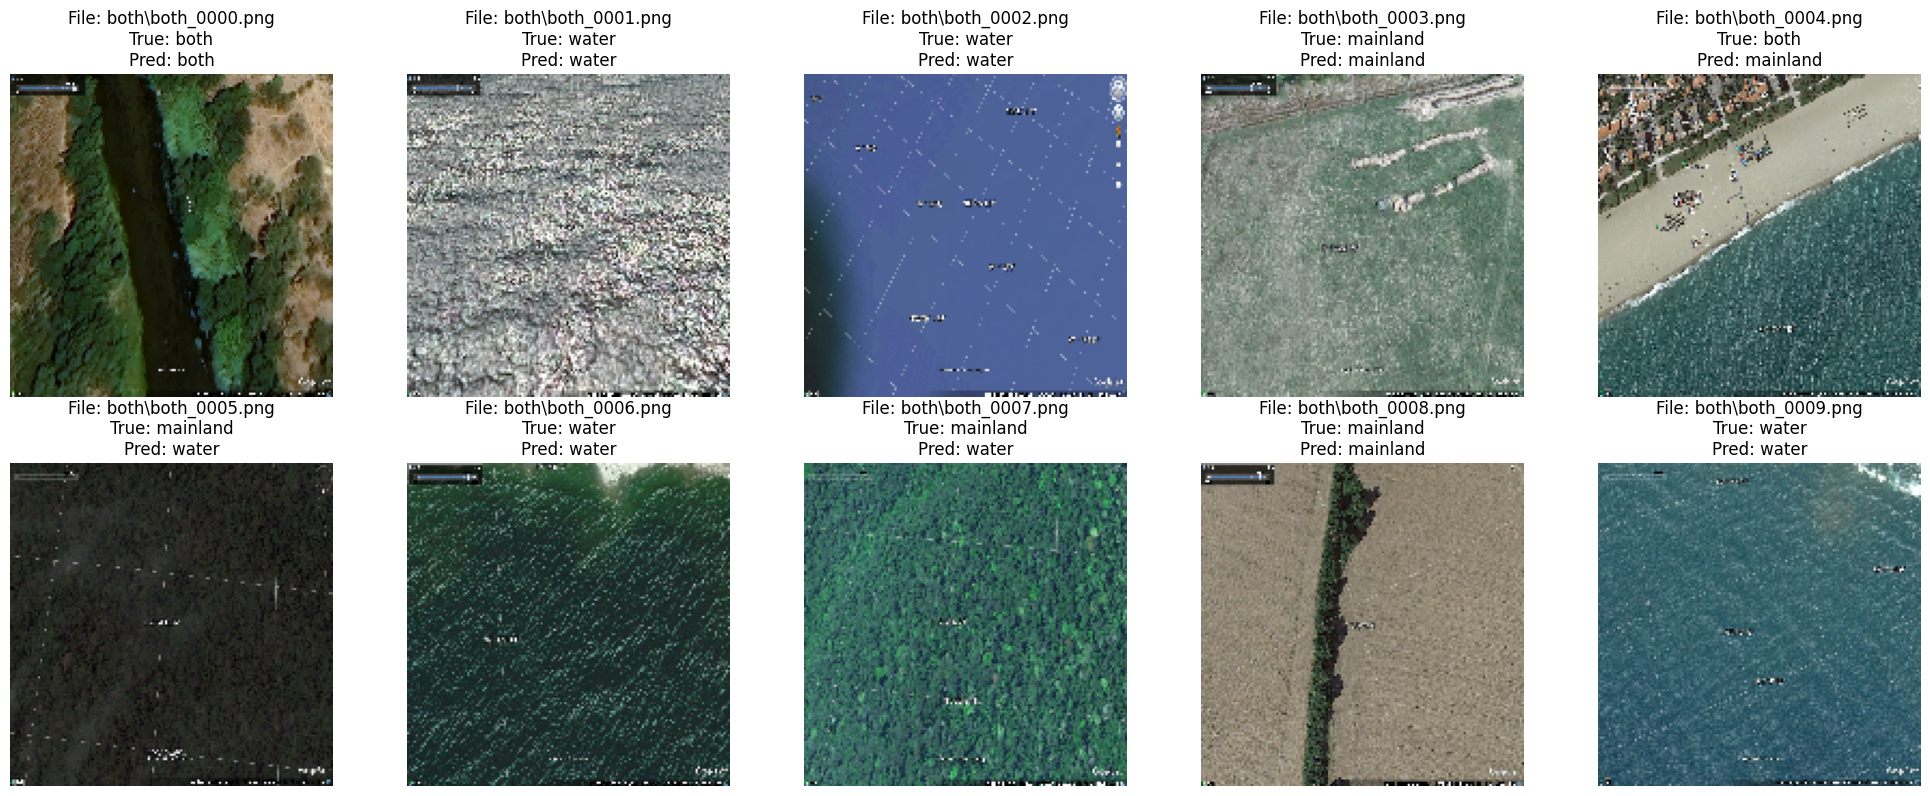

Epoch Progress:  20%|██        | 1/5 [20:25<1:21:40, 1225.09s/it]

Starting epoch 102 to 112
Epoch 103/112
38/38 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.8106 - auc: 0.9364 - loss: 0.6085 - precision: 0.8457 - recall: 0.7707 - val_accuracy: 0.7284 - val_auc: 0.8691 - val_loss: 0.8089 - val_precision: 0.7467 - val_recall: 0.6914 - learning_rate: 2.0000e-04
Epoch 104/112
38/38 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.8054 - auc: 0.9268 - loss: 0.6313 - precision: 0.8375 - recall: 0.7698 - val_accuracy: 0.7160 - val_auc: 0.8608 - val_loss: 0.8366 - val_precision: 0.7399 - val_recall: 0.6790 - learning_rate: 2.0000e-04
Epoch 105/112
38/38 ━━━━━━━━━━━━━━━━━━━━ 1559s 41s/step - accuracy: 0.7990 - auc: 0.9314 - loss: 0.6167 - precision: 0.8286 - recall: 0.7505 - val_accuracy: 0.7243 - val_auc: 0.8662 - val_loss: 0.8157 - val_precision: 0.7467 - val_recall: 0.6914 - learning_rate: 2.0000e-04
Epoch 106/112
38/38 ━━━━━━━━━━━━━━━━━━━━ 285s 7s/step - accuracy: 0.8019 - auc: 0.9324 - loss: 0.6065 - precision: 0.8291 - recall: 0.7738 - val_accuracy: 0

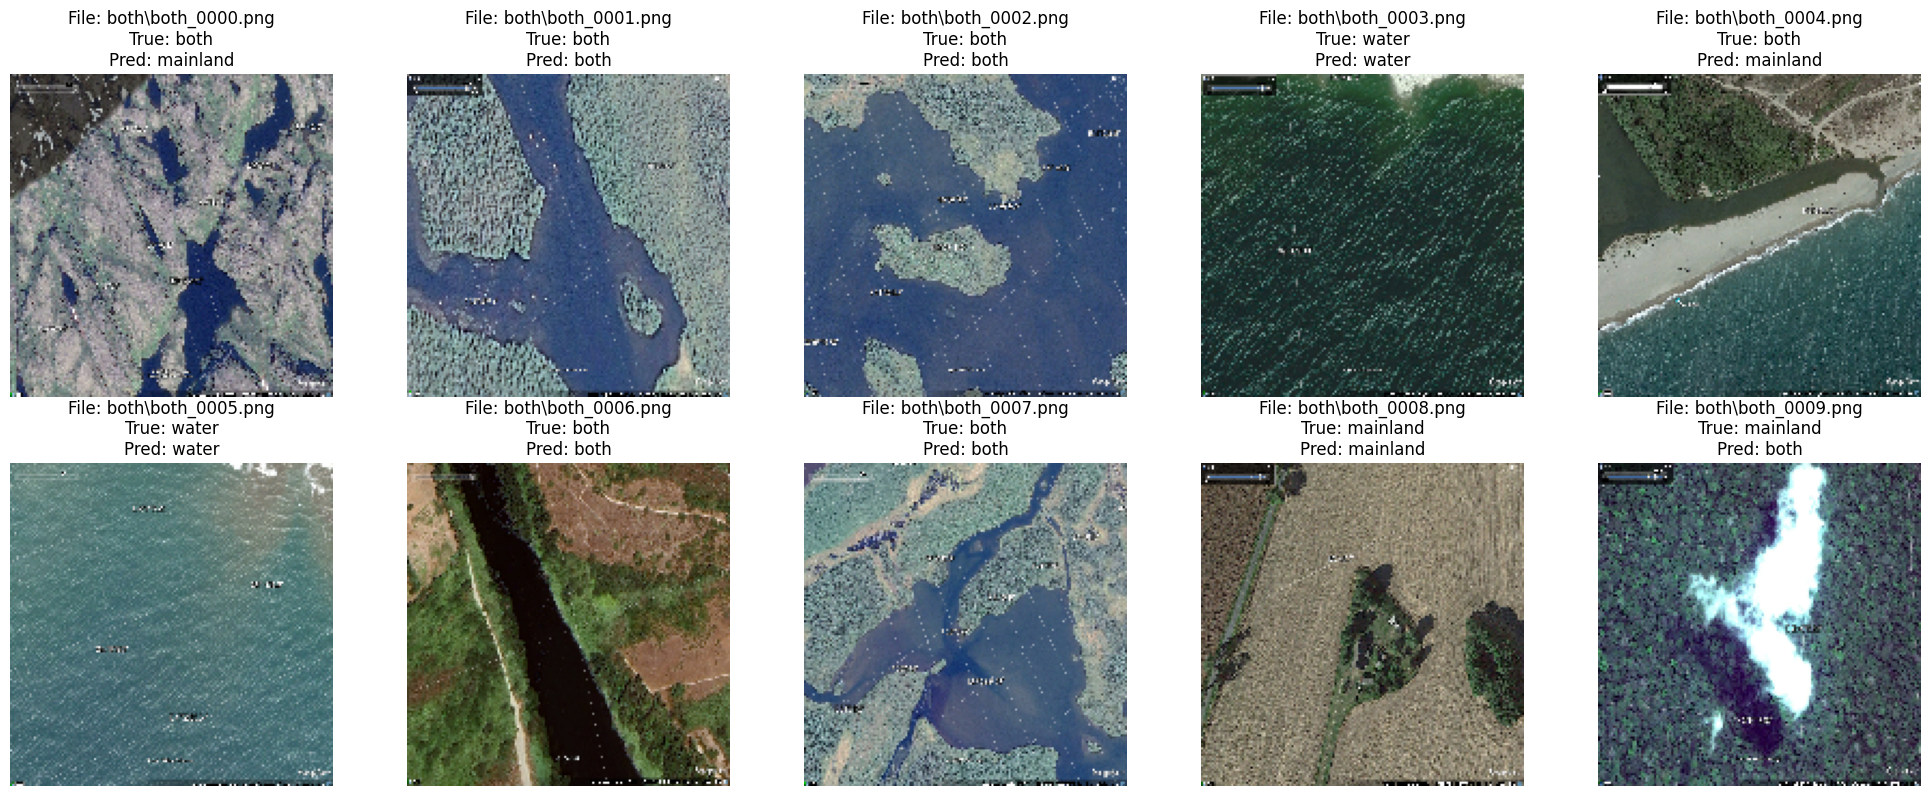

Epoch Progress:  40%|████      | 2/5 [1:06:47<1:47:04, 2141.43s/it]

Starting epoch 112 to 122
Epoch 113/122
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8161 - auc: 0.9417 - loss: 0.5780 - precision: 0.8376 - recall: 0.7775 - val_accuracy: 0.7284 - val_auc: 0.8686 - val_loss: 0.7968 - val_precision: 0.7424 - val_recall: 0.6996 - learning_rate: 2.0000e-04
Epoch 114/122
38/38 ━━━━━━━━━━━━━━━━━━━━ 302s 8s/step - accuracy: 0.8183 - auc: 0.9392 - loss: 0.5867 - precision: 0.8443 - recall: 0.7736 - val_accuracy: 0.7284 - val_auc: 0.8719 - val_loss: 0.7858 - val_precision: 0.7393 - val_recall: 0.7119 - learning_rate: 2.0000e-04
Epoch 115/122
38/38 ━━━━━━━━━━━━━━━━━━━━ 300s 8s/step - accuracy: 0.8028 - auc: 0.9290 - loss: 0.6153 - precision: 0.8262 - recall: 0.7654 - val_accuracy: 0.7078 - val_auc: 0.8534 - val_loss: 0.8517 - val_precision: 0.7229 - val_recall: 0.6872 - learning_rate: 2.0000e-04
Epoch 116/122
38/38 ━━━━━━━━━━━━━━━━━━━━ 298s 7s/step - accuracy: 0.8222 - auc: 0.9459 - loss: 0.5609 - precision: 0.8520 - recall: 0.7797 - val_accuracy: 0.73

In [19]:
# Check if model file exists
model_file = 'coastline_classifier.keras'
metrics_file = 'training_metrics.json'
if os.path.exists(model_file):
    # Choose mode of operation: retrain, additional epochs, or skip training
    mode = input("Model found. Enter mode (retrain/continue/skip): ").strip().lower()

    if mode == 'retrain':
        # Choose model type: custom or pretrained
        model_choice = input("Choose model type (custom/pretrained): ").strip().lower()
        if model_choice == 'pretrained':
            pretrained_model_name = input("Enter pretrained model name (vgg16/resnet50/inceptionv3): ").strip().lower()
            model = build_pretrained_model(pretrained_model_name)
        else:
            model = build_custom_model()
        print("Starting training from scratch...")
    elif mode == 'continue':
        model = load_model(model_file)
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
        metrics = load_metrics_from_json(metrics_file)
        if metrics:
            start_epoch = len(metrics['accuracy'])
        print("Loaded existing model. Continuing training from epoch", start_epoch)
    elif mode == 'skip':
        if os.path.exists(model_file):
            model = load_model(model_file)
            model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
            history = None
            print("Loaded existing model. Skipping training...")
        else:
            print("Model not found. Cannot skip training.")
            exit()
    else:
        print("Invalid mode. Defaulting to retrain.")
        model_choice = input("Choose model type (custom/pretrained): ").strip().lower()
        if model_choice == 'pretrained':
            pretrained_model_name = input("Enter pretrained model name (vgg16/resnet50/inceptionv3): ").strip().lower()
            model = build_pretrained_model(pretrained_model_name)
        else:
            model = build_custom_model()
        print("Starting training from scratch...")
else:
    print("No existing model found. Starting training from scratch...")
    model_choice = input("Choose model type (custom/pretrained): ").strip().lower()
    if model_choice == 'pretrained':
        pretrained_model_name = input("Enter pretrained model name (vgg16/resnet50/inceptionv3): ").strip().lower()
        model = build_pretrained_model(pretrained_model_name)
    else:
        model = build_custom_model()
    mode = 'retrain'


if mode != 'skip':
    # Train the model with early stopping, ModelCheckpoint, and TensorBoard
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    tensorboard_callback = TensorBoard(log_dir='./logs')
    checkpoint_callback = ModelCheckpoint(filepath='coastline_classifier_epoch_{epoch:02d}.keras', save_freq='epoch')
    
    print("Starting model training...")
    for epoch in tqdm(range(start_epoch, start_epoch + epochs, 10), desc="Epoch Progress"):
        print(f"Starting epoch {epoch} to {epoch + 10}")
        history = model.fit(
            train_generator,
            initial_epoch=epoch,
            epochs=epoch + 10,
            validation_data=validation_generator,
            callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint_callback]
        )
        next_model_file = get_next_model_filename()
        model.save(next_model_file)
        print(f"Model saved as {next_model_file}")
        display_predictions(model, validation_generator)

    print("Model training completed.")

    # Save the final model
    next_model_file = get_next_model_filename()
    model.save(next_model_file)
    model.save(model_file)
    print(f"Model saved as {next_model_file} and {model_file}")

    # Save metrics to JSON
    save_metrics_to_json(history, metrics_file, start_epoch)

    if mode == 'retrain' and model_choice == 'pretrained':
        # Fine-tune the model
        print("Starting fine-tuning...")
        model = fine_tune_model(model, pretrained_model_name)
        for epoch in tqdm(range(start_epoch, start_epoch + epochs, 10), desc="Epoch Progress - Fine-tuning"):
            history = model.fit(
                train_generator,
                initial_epoch=epoch,
                epochs=epoch + 10,
                validation_data=validation_generator,
                callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint_callback]
            )
            # Save the fine-tuned model
            next_model_file = get_next_model_filename()
            model.save(next_model_file)
            print(f"Fine-tuned model saved as {next_model_file} and {model_file}")
            display_predictions(model, validation_generator)
        # Save metrics to JSON
        save_metrics_to_json(history, metrics_file, start_epoch)
    
if history:
    # Plot training & validation accuracy and loss values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['precision'], label='Precision')
    plt.plot(history.history['recall'], label='Recall')
    plt.plot(history.history['auc'], label='AUC')
    plt.title('Model Accuracy and Additional Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    history_plot_file = generate_filename('training_history', start_epoch, start_epoch + epochs)
    plt.savefig(history_plot_file)
    plt.show()
    print(f"Training history plot saved as {history_plot_file}")

# Evaluate the model on validation data
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = validation_generator.classes

# Additional metrics
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")
print(f"Matthews Correlation Coefficient: {mcc}")

# Classification report
report = classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys())
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
confusion_matrix_file = generate_filename('confusion_matrix', start_epoch, start_epoch + epochs)
plt.savefig(confusion_matrix_file)
plt.show()
print(f"Confusion matrix saved as {confusion_matrix_file}")

# Ensemble Learning
print("Starting ensemble learning...")
model_files = [f for f in os.listdir() if f.startswith('coastline_classifier_') and f.endswith('.keras')]
models = [load_model(file) for file in model_files]

# Ensemble predictions
ensemble_pred = ensemble_predictions(models, validation_generator)
ensemble_f1 = f1_score(y_true, ensemble_pred, average='weighted')
ensemble_kappa = cohen_kappa_score(y_true, ensemble_pred)
ensemble_mcc = matthews_corrcoef(y_true, ensemble_pred)

print(f"Ensemble F1 Score: {ensemble_f1}")
print(f"Ensemble Cohen's Kappa: {ensemble_kappa}")
print(f"Ensemble Matthews Correlation Coefficient: {ensemble_mcc}")

# Ensemble classification report
ensemble_report = classification_report(y_true, ensemble_pred, target_names=validation_generator.class_indices.keys())
print(ensemble_report)

# Ensemble confusion matrix
ensemble_cm = confusion_matrix(y_true, ensemble_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
ensemble_confusion_matrix_file = 'ensemble_confusion_matrix.png'
plt.savefig(ensemble_confusion_matrix_file)
plt.show()
print(f"Ensemble confusion matrix saved as {ensemble_confusion_matrix_file}")

# Include the SWED dataset (Both category in classification for SWED dataset, so need to extract water and mainland from that dataset to train the classification model to understand that datas too ... so requires to modify the SWED dataset a little bit)

In [ ]:
#the SWED dataset
#the npy dataset use the same color so we can do autolabelling and do automatic extraction for categorical classification



# Other datasets to implement to the classification model

# Generic Machine Learning Model for Coastline Identification

## Project Overview

This project aims to develop a generic machine learning model capable of identifying coastlines from any given image. Leveraging the previously developed classification algorithm, the objective is to create a robust and adaptable model that can accurately discern between mainland, water, and both in images from diverse sources.

## Motivation

Traditional machine learning models for coastline detection are often tailored to specific datasets or satellite imagery sources, limiting their applicability across different image types. This project addresses the need for a versatile solution by training the model on a diverse set of images, ensuring it can handle various resolutions and perspectives, including high-resolution images from sources like Google Earth.

## Methodology

### Data Collection

To build a comprehensive dataset, images are sourced from multiple platforms, including Google Earth, SWED, and Landsat. The dataset is categorized into three classes: mainland, water, and both. Each category contains a balanced number of images to prevent bias during training.

### Preprocessing

Images undergo several preprocessing steps to enhance model performance:

- **Rescaling**: Adjusting pixel values to a standard range.
- **Augmentation**: Applying random transformations such as rotation, zoom, and horizontal flipping to increase the dataset's diversity and robustness.

### Model Architecture

Two types of models are developed:

1. **Custom CNN Model**: A convolutional neural network designed from scratch, consisting of multiple convolutional and pooling layers, followed by fully connected layers.

2. **Pretrained Models**: Leveraging transfer learning, models like VGG16, ResNet50, and InceptionV3 are fine-tuned on the dataset. The final layers are replaced with task-specific layers to adapt the models for coastline classification.

### Training and Validation

The model is trained using the Adam optimizer and categorical cross-entropy loss function. Early stopping and learning rate reduction on plateau are implemented to enhance training efficiency and prevent overfitting. Every 10 epochs, the model's performance is evaluated, and predictions are visualized to monitor progress.

### Evaluation Metrics

To comprehensively evaluate the model, several metrics are used:

- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**
- **Cohen's Kappa**
- **Matthews Correlation Coefficient (MCC)**
- **Area Under the Curve (AUC)**

### Ensemble Learning

An ensemble of models is created to further improve performance. Predictions from multiple trained models are combined, and the final decision is made based on majority voting or averaging, enhancing the model's robustness and accuracy.

## Results

The model demonstrates promising results in accurately identifying coastlines across various image sources. The use of ensemble learning and transfer learning significantly boosts performance, achieving high precision and recall.

## Future Work

Future improvements include:

- Expanding the dataset with more diverse images.
- Implementing advanced augmentation techniques.
- Exploring other pretrained models and ensemble methods.
- Deploying the model in an interactive map application for real-time coastline detection.

## Conclusion

This project showcases the potential of machine learning in creating a flexible and efficient model for coastline identification. By integrating various data sources and employing sophisticated training techniques, the model sets a foundation for future advancements in geographic image analysis.

## Additional Feature: Auto-labeling for Coastline Identification

Building on the developed classification model, an additional feature for auto-labeling images will be integrated. The goal is to identify the coastline, which is the interaction zone between mainland and water. This will enhance the model's utility in real-world applications by automatically labeling images and identifying the coastline area without manual intervention.

### Implementation

1. **Classification Model Integration**: Utilize the existing classification model to categorize image regions into mainland, water, and both.
2. **Auto-labeling Algorithm**: Develop an algorithm to detect and highlight the coastline by identifying the boundaries where mainland and water regions meet.
3. **Visualization**: Implement visualization tools to display the detected coastline on images, providing a clear and interactive representation for users.

This feature will significantly improve the model's applicability, making it a powerful tool for geospatial analysis and environmental monitoring.

---

By incorporating this auto-labeling feature, the project aims to provide a comprehensive solution for coastline identification, leveraging advanced machine learning techniques to handle various image sources and conditions.


In [ ]:
#python code for Auto-labeling Algorithm
#purple for mainland and yellow for water in both images 
#then use edge detection or color / smeantic segmentation to identify the coastline

## Annex

### Technical Details
- **Software**: Libraries and frameworks used (TensorFlow, Keras, etc.).

### Additional Data
- **Training Logs**: Detailed logs of the training process.